In [0]:
# Helps to reinit the colab to get the Tesla T4
!kill -9 -1

In [1]:
# Verify that the GPU is Tesla T4, Compute Capability 7.5, 
# 4x faster then the Tesla K80, Compute Capability 3.7, 
# if not reinitialise
!nvidia-smi

Sun Aug 11 20:03:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#install the libraries
!pip install selenium
!pip install tensorflow
!pip install Pillow
!pip install plotly
!pip install dill
!pip install git+git://github.com/scikit-optimize/scikit-optimize.git # PyPI doesnt have the latest version of scikit optimize that has checkpointsaver
!pip install -U git+https://github.com/mattiavarile/efficientnet # this specific efficientnet is coded with tensorflow keras and not keras

     |████████████████████████████████| 911kB 1.4MB/s 
  Cloning git://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-72qg1aac
  Running command git clone -q git://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-72qg1aac
  Created wheel for scikit-optimize: filename=scikit_optimize-0.6+3.g6740876-py2.py3-none-any.whl size=75044 sha256=3791b9f4e9ecc79f61a4703be6fc9827094a4ef4183fbecbba82c814d17ed812
  Stored in directory: /tmp/pip-ephem-wheel-cache-b7b_5ttb/wheels/87/8f/00/55cc0281663e6264de266909eb75d07afb935bde4e34d12c3e
Successfully built scikit-optimize
  Cloning https://github.com/mattiavarile/efficientnet to /tmp/pip-req-build-as440rsv
  Running command git clone -q https://github.com/mattiavarile/efficientnet /tmp/pip-req-build-as440rsv
  Created wheel for efficientnet: filename=efficientnet-0.0.3-cp36-none-any.whl size=11753 sha256=2f17a335b0717aad3986ac07774327e5d790a6a596e4f2146a7744fafa6e3fdf
  Stored in directory: /tmp/pip-ephem-wheel-

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# import librairies
from google import colab
import json
import tensorflow as tf
import tensorboard as tb
from importlib import reload

print("Tensorflow version " + tf.__version__)
print("Tensorboard version " + tb.__version__)

# Choose the bucket name and project
BUCKET = 'gs://ai-decathlon-canada'

# PROJECT = 'decathon_classes_1_shard'
# PROJECT = 'decathon_classes_16_train_shard'
# PROJECT = 'decathon_classes_32_train_shard'
# PROJECT = 'parent_sport_classificationV3'
# PROJECT = 'parent_sport_classificationV4'
# PROJECT = 'parent_sport_classificationV4_w_da'
# PROJECT = 'parent_sport_classificationV5_w_da'
PROJECT = 'parent_sport_classificationV6_w_da'
# PROJECT = 'hockey_community'
# PROJECT = 'all_sport_groups'

Tensorflow version 1.14.0
Tensorboard version 1.14.0


In [4]:
# get image classification repo
%cd /content/
if tf.gfile.Exists('./image-classification'):
  tf.gfile.DeleteRecursively('./image-classification')
!git clone --branch tpu_bucket_dev https://github.com/decathloncanada/image-classification.git
!ls

/content
Cloning into 'image-classification'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 1621 (delta 115), reused 139 (delta 93), pack-reused 1456
Receiving objects: 100% (1621/1621), 241.84 MiB | 41.84 MiB/s, done.
Resolving deltas: 100% (363/363), done.
image-classification  sample_data


In [5]:
# google authentification
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 1.4MB/s 


In [16]:
# Get one of the image dataset from the drive
%cd /content/image-classification/
!ls
#step 4: get the file ID (you can get it from the sharing link - obtenir le lien partagé...)
#file_id = '1UDAlCGH72TdkNjVq6nvJqDStzR9L5o-P' #hockey dataset from google images
#file_id = '1bbeVpJwHpyUMOE3P11f_71ntTTW4jX_T' #hockey dataset from HC
#file_id = '12r-vS0TwCpwiAnHYT0RQ-EUzYuXogK8W' #hockey brand dataset from sidelineswap
#file_id = '1BMKeo9M_dZAVOEc0nLxKVOBp8a5r_CXl' #sport dataset
#file_id = '1S5-wkB2G_1XlefifTXKN0468_YqzFPsV' #smaller sport group dataset
#file_id = '1oVdkRyQGA6td9bwzU0G6Jmyu0Bco_SJn' #all sport groups dataset
#file_id = '1GMf_KD699pKm2wJgY-fikWlYuIYwVjIG' #all parents sport category
#file_id = '15fpLCGKCG_TA_ixuNJIt8oP4KTaQQUth' #all parents sport category V2
#file_id = '1EQ3UhdTP-3jYOeRW4O-kUK-_7s34BzKk' #all parents sport category V3
#file_id = '1iN3_sEde_gLaWNxesFPzjmEOOUcAUQto' #all parents sport category V4
#file_id = '1OjB-Kftb3F0C602bbkweAV-GFAygKum-' #all parents sport category V4 with data augmentation
#file_id = '1FL3vNOI7QQHMAKsX7FThcudc8zmu8bno' #all parents sport category V5 with data augmentation
file_id = '1J-0wsKEwGRSQd7oO63kRAL_3ZZtS5Ti7' #all parents sport category V6 with data augmentation
#file_id = '1EEp5CtJxrrScfRiIp8xN3Chk_YeB67T7' # decathlon classes

#step 5: extract the file to the data folder (with name "name_folder")
name_folder = 'image_dataset'
%cd data/
fileId = drive.CreateFile({'id': file_id}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])
# 7z is required files larger than 4 Gb
fileId.GetContentFile(name_folder + '.7z')  # Save Drive file as a local file
!ls
#step 6: unzip the folder and delete zip
!p7zip -d 'image_dataset.7z'

/content/image-classification
app.py	debug.log  main.py    README.md		src   utils
data	LICENSE    notebooks  requirements.txt	test
/content/image-classification/data
all_sports_parent_groupV6_w_da.7z
image_dataset.7z  searchterms.csv  trained_models

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 568639750 bytes (543 MiB)

Extracting archive: image_dataset.7z
--
Path = image_dataset.7z
Type = 7z
Physical Size = 568639750
Headers Size = 867568
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 460          1% 831 - image_dataset/train/aeromodeli . 8b2-43db-b00f-149695b770b4.jpg                                                                          

In [0]:
# Exemple of how to use the custom load model for transfer learning
%cd /content/image-classification/utils/
import utils;reload(utils)
model = utils.load_model(path='/content/image-classification/data/trained_models/trained_model.h5', include_top=False)
model.summary()
x = model.output
predictions = tf.keras.layers.Dense(333, activation='softmax', name='prediction_layer')(x)
new_model = tf.keras.Model(inputs=model.input, outputs=predictions)
new_model.summary()

In [0]:
# Split dataset if needed
import utils;reload(utils)
utils.split_train(split=0.15)

In [17]:
# Verify that tpu or gpu is available and working
try:
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # TPU detection
  use_tpu = True
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
except ValueError:
  if tf.test.is_built_with_cuda():
    print("Running on GPU")
    print(tf.test.gpu_device_name())
  else:
    print("Running on CPU")
  use_tpu = False
  tpu = None

Running on GPU
/device:GPU:0


In [18]:
# Get the GCS directories
data_dir = os.path.join(os.path.join(BUCKET, 'data'), PROJECT)
work_dir = os.path.join(os.path.join(BUCKET, 'work'), PROJECT)
train_fn = os.path.join(data_dir, "train") # prefix for output file names
val_fn = os.path.join(data_dir, "val") # prefix for output file names
print('Data dir= '+data_dir)
print('Work dir= '+work_dir)
print('Train dir= '+train_fn)
print('Val dir= '+val_fn)

Data dir= gs://ai-decathlon-canada/data/parent_sport_classificationV6_w_da
Work dir= gs://ai-decathlon-canada/work/parent_sport_classificationV6_w_da
Train dir= gs://ai-decathlon-canada/data/parent_sport_classificationV6_w_da/train
Val dir= gs://ai-decathlon-canada/data/parent_sport_classificationV6_w_da/val


In [0]:
# generate tfrecords and updload to gcs
parentdir = '/content/image-classification'
%cd /content/image-classification/src
!ls
import generate_tfrecords;reload(generate_tfrecords)
from generate_tfrecords import TfrecordsGenerator
generator = TfrecordsGenerator()

generator.convert_image_folder(img_folder=parentdir+'/data/image_dataset/train', ouput_folder=train_fn, shards=1)
print('tfrecords generated and saved at '+ train_fn)
generator.convert_image_folder(img_folder=parentdir+'/data/image_dataset/val', ouput_folder=val_fn, shards=1)
print('tfrecords generated and saved at '+ val_fn)

In [0]:
# delete and reupload a file if needed, if quick changes are needed
%cd /content/image-classification/test/
!ls

# remove a file
if tf.gfile.Exists('image_classifier_tfrecords.py'):
  tf.gfile.Remove('image_classifier_tfrecords.py')
!ls

# upload new version
colab.files.upload()
!ls

In [0]:
# Training
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                              batch_size=128, transfer_model='B3')
classifier.fit(epochs=50, learning_rate=1e-4, l2_lambda=1e-3, activation='swish', dropout=0.9, save_model=False, logs=None)

In [0]:
# Fitness
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                                 batch_size=128, transfer_model='B3')
classifier.hyperparameter_optimization(num_iterations=28, n_random_starts=12)
%cd /content/image-classification/data/trained_models/
!ls
# download pickle files
colab.files.download("hyperparameters_dimensions.pickle")
colab.files.download("hyperparameters_search.pickle")

In [0]:
# upload hyperparameters
if not tf.gfile.Exists('/content/image-classification/data/trained_models'):
  tf.gfile.MkDir('/content/image-classification/data/trained_models')
%cd /content/image-classification/data/trained_models
f.files.upload()

In [0]:
#load the optimized hypermeters
import dill
with open('hyperparameters_dimensions.pickle', 'rb') as f:
    dimensions = dill.load(f)
with open('hyperparameters_search.pickle', 'rb') as f:
    sr = dill.load(f)
opt_params = {dimensions[i].name:sr[i] for i in range(len(dimensions))}
opt_params['activation'] = 'relu'
print(opt_params)

In [0]:
# go to parent dir
%cd /content/image-classification/test/
!ls


#Fit the model to extract SavedModel with optimized hyparameters
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                                 batch_size=128, transfer_model='Inception')
classifier.fit(**opt_params, save_model=True)

In [0]:
%cd /content/image-classification/data/trained_models/
!ls
# download saved model files
colab.files.download("trained_model.h5")

In [9]:
# load trained model from the drive
if not tf.gfile.Exists('/content/image-classification/data/trained_models'):
  tf.gfile.MkDir('/content/image-classification/data/trained_models')
elif tf.gfile.Exists('/content/image-classification/data/trained_models/trained_model.h5'):
  tf.gfile.Remove('/content/image-classification/data/trained_models/trained_model.h5')
%cd /content/image-classification/data/trained_models
!ls

# file_id = '1u5ReTlvbtkYEBrffkPr_or5NSplSRBlE' # trained model V4
# file_id = '1omyMkaq9t1MM9BiPE1j6oGU52zeKaDh4' # trained model V5
# file_id = '1F-59rOMPzUata9yGdRhgd-w7VkOS-o50' # trained model V6 B3
file_id = '1BcLOl6jffltXdRnew4m0eV1InSoT6e-w' # trained model V6 B5
# file_id = '1lAfdCFpG8er3vVLumOHTbR-zcHhkXZmj' # trained model Deca B3
# file_id = '1KNvbIXNpX8p1Ce3T29nvcll2Gf5cQv8-' # trained model Deca B5
#file_id = '16UVkp4A4IbzwcllDecf4dZ2EgTXoc30F' # trained model group sports

fileId = drive.CreateFile({'id': file_id}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])
fileId.GetContentFile('trained_model.h5')  # Save Drive file as a local file
!ls

/content/image-classification/data/trained_models
trained_model-V6-B5.h5
trained_model.h5


In [0]:
# Export a tensorflow model to a serving format
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                              batch_size=128, transfer_model='B5',
                             load_model=True)

classifier.export_saved_model('/content/image-classification/test/image_classifier/1/')

Classes (333) :
['1-PIECE SWIMSUI', '2 PIECES SWIMSU', 'ADAPTOR', 'ADDITIVE', 'AQUASHOES', 'ARM COVER', 'ARROW', 'BACKPACK', 'BADMINTON RACKE', 'BAG', 'BAIT', 'BALACLAVA', 'BALL', 'BANDANA', 'BASE LAYER', 'BASEBALL BAT', 'BASKET BALL', 'BATHROBE', 'BATTERY', 'BEANIE', 'BELT', 'BERMUDA SHORTS', 'BIB', 'BIKE', 'BIKE COMPUTER', 'BIKE GUARD', 'BIKE LIGHT', 'BIKE PANNIER', 'BIKE SADDLE', 'BIKINI', 'BIKINI BOTTOM', 'BIKINI TOP', 'BINDING', 'BINOCULARS', 'BMX', 'BOARDSHORTS', 'BOAT', 'BOILIES', 'BOMBETTE', 'BOOTS, BOOTIES', 'BOULE', 'BOW', 'BOXER SHORTS', 'BRA', 'BRAKE LEVER', 'BRAKE PAD', 'BRAKE PADS', 'BREECHES', 'BRIDLE', 'BRIEFS', 'BRUSH', 'CAMP STOVE', 'CANOE-KAYAK', 'CAP', 'CARRY BAG', 'CASSETTE', 'CEREAL BAR', 'CHAINSET', 'CHAIR', 'CHILD BIKE', 'CHOCOLATE', 'CITY BIKE', 'CLEATED SHOES', 'CLIMBING ROPE', 'COLLAR', 'COMMUNICATION S', 'COOKSET', 'COOLER BOX', 'CROPPED LEGGING', 'CROPPED TROUSER', 'CROSS TRAINER', 'CUP', 'CYCLE RACK', 'DART', 'DARTBOARD', 'DECOY', 'DEHYDRATED MEAL', 'DEODO

W0723 14:02:35.313304 139926856517504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 14:02:35.319307 139926856517504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 14:02:35.324785 139926856517504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is depr

Test images = 333
Training shard size = 5520
Val shard size = 9684
Training batch size = 128
Training steps per epochs = 689
Val batch size = 128
Val steps per epochs = 75


W0723 14:02:35.594207 139926856517504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 14:02:35.601866 139926856517504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/efficientnet/initializers.py:30: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0723 14:02:36.090105 139926856517504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 14:02:36.210687 139926856517504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/a

Model loaded !


W0723 14:02:54.680588 139926856517504 deprecation.py:323] From /content/image-classification/test/image_classifier_tfrecords.py:501: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
W0723 14:02:54.681614 139926856517504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Model extracted!


In [0]:
# load test images
%cd /content/image-classification/data/
!ls
colab.files.upload()

In [0]:
# go to parent dir
%cd /content/image-classification/test/
!ls

data_folder = '/content/image-classification/data/'
# Predict all image from a folder
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                              batch_size=128, transfer_model='B3',
                              load_model=True)
classifier.classify_images(image_path=data_folder)

In [0]:
# go to parent dir
%cd /content/image-classification/test/
!ls

# display tool
# Plotly account required, see https://plot.ly/python/getting-started/
# import plotly
# plotly.tools.set_credentials_file(username='', api_key='')
import plotly 
plotly.tools.set_credentials_file(username='leo.landry', api_key='l5ripkTigBVcouT6OgSx')

# get the confusion matrix and go to https://plot.ly/organize/home/ visualize
import image_classifier_tfrecords as ic
reload(ic)
classifier = ic.image_classifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                                 batch_size=128, transfer_model='Xception',
                                 load_model=True)
classifier.confusion_matrix(filename='labelled-heatmap-w_da', normalize=True)

/content/image-classification/test
image_classifier			image_classifier_tfrecords.py
image_classifier_from_tensor_slices.py	__pycache__
Classes (333) :
['1-PIECE SWIMSUI', '2 PIECES SWIMSU', 'ADAPTOR', 'ADDITIVE', 'AQUASHOES', 'ARM COVER', 'ARROW', 'BACKPACK', 'BADMINTON RACKE', 'BAG', 'BAIT', 'BALACLAVA', 'BALL', 'BANDANA', 'BASE LAYER', 'BASEBALL BAT', 'BASKET BALL', 'BATHROBE', 'BATTERY', 'BEANIE', 'BELT', 'BERMUDA SHORTS', 'BIB', 'BIKE', 'BIKE COMPUTER', 'BIKE GUARD', 'BIKE LIGHT', 'BIKE PANNIER', 'BIKE SADDLE', 'BIKINI', 'BIKINI BOTTOM', 'BIKINI TOP', 'BINDING', 'BINOCULARS', 'BMX', 'BOARDSHORTS', 'BOAT', 'BOILIES', 'BOMBETTE', 'BOOTS, BOOTIES', 'BOULE', 'BOW', 'BOXER SHORTS', 'BRA', 'BRAKE LEVER', 'BRAKE PAD', 'BRAKE PADS', 'BREECHES', 'BRIDLE', 'BRIEFS', 'BRUSH', 'CAMP STOVE', 'CANOE-KAYAK', 'CAP', 'CARRY BAG', 'CASSETTE', 'CEREAL BAR', 'CHAINSET', 'CHAIR', 'CHILD BIKE', 'CHOCOLATE', 'CITY BIKE', 'CLEATED SHOES', 'CLIMBING ROPE', 'COLLAR', 'COMMUNICATION S', 'COOKSET', 'COOLER BO

W0723 14:03:29.721031 139926856517504 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model loaded !


W0723 14:05:35.053160 139926856517504 deprecation.py:323] From /content/image-classification/test/image_classifier_tfrecords.py:273: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0723 14:05:35.073360 139926856517504 deprecation_wrapper.py:119] From /content/image-classification/test/image_classifier_tfrecords.py:274: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Predictions labels loaded
True labels loaded


/content/image-classification/test
image_classifier_from_tensor_slices.py	__pycache__
image_classifier_tfrecords.py
Classes (152) :
['aerobatics', 'aeromodeling', 'air_racing', 'airsoft', 'aquafit', 'aquathlon', 'archery', 'artistic_cycling', 'axe_throwing', 'badminton', 'ballet', 'ballooning', 'bandy', 'baseball', 'basketball', 'basque_rural_sports', 'biathlon', 'bike_and_run', 'blackball', 'bmx', 'bobsleigh', 'boomerang', 'boules', 'boxing', 'camping', 'canoeing', 'cardio_training', 'carom_billiards', 'cestoball', 'cheerleading', 'climbing', 'cricket', 'curling', 'dance', 'danish_longball', 'darts', 'diving', 'dragon_boat', 'duathlon', 'fatbike', 'fencing', 'fishing', 'fitness', 'fitness_dance', 'floor_hockey', 'football', 'footvolley', 'freestyle_skiing', 'frescobol', 'frisbee', 'gliding', 'golf', 'golfcross', 'grappling', 'gymnastics', 'handball', 'hang_gliding', 'helicopter', 'hiking', 'hockey', 'horse_competition', 'horseback_riding', 'horseback_western_riding', 'hunting', 'hybri

W0811 20:15:56.957941 140429746685824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 20:15:56.965746 140429746685824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 20:15:56.972218 140429746685824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is depr

Model loaded !


W0811 20:16:50.117435 140429746685824 deprecation.py:323] From /content/image-classification/test/image_classifier_tfrecords.py:366: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0811 20:16:50.145047 140429746685824 deprecation_wrapper.py:119] From /content/image-classification/test/image_classifier_tfrecords.py:367: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Predictions labels loaded
True labels loaded
random_errors :
[269, 489, 667, 775, 783, 811, 1032, 1332, 1469]
Images loaded


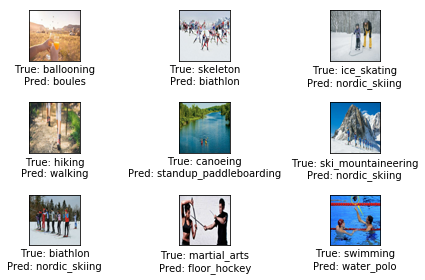

In [19]:
# go to parent dir
%cd /content/image-classification/test/
!ls

# plot 9 errors to visualize predictions mistakes
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                              batch_size=128, transfer_model='B5',
                              load_model=True)
classifier.plot_errors()

In [0]:
# go to parent dir
%cd /content/image-classification/test/
!ls

# evaluate model metric
import image_classifier_tfrecords;reload(image_classifier_tfrecords)
from image_classifier_tfrecords import ImageClassifier
classifier = ImageClassifier(tfrecords_folder=data_dir, use_TPU=use_tpu, 
                              batch_size=128, transfer_model='B5',
                              load_model=True)
classifier.evaluate()